# Interpretation and Visualization of Traffic Data. 
- Database of traffic radars in the city of São Paulo, Brazil.
- Import of data/traffic_data.feather

## 1 - Import the Dataset

**Feather** is an optimized data storing format. Thus, in order to use it, it is necessary to import its API.

The *feather()* method already imports the dataser as a Pandas.DataFrame

In [1]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10
# import
import feather

# Dataset reading
path = 'data/traffic_data.feather'
df = feather.read_dataframe(path)

In [2]:
# Dataframe
df

,index,passage,direction,type,region,timestamp,jam_size,segment
0,0,"Jânio Quadros, Túnel",unico//,NaN,OESTE,2015-01-04 14:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
1,1,"Juscelino Kubitschek, Av Pres",Ibirapuera/Pinheiros,NaN,SUL,2015-01-04 14:30:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
2,2,"Jânio Quadros, Túnel",unico//,NaN,OESTE,2015-01-04 15:00:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
3,3,"Juscelino Kubitschek, Av Pres",Ibirapuera/Pinheiros,NaN,SUL,2015-01-04 15:00:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
4,4,"Jânio Quadros, Túnel",unico//,NaN,OESTE,2015-01-04 15:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
...,...,...,...,...,...,...,...,...
5223443,230195,Marginal Pinheiros,Interlagos/Castelo,A,OESTE,2018-09-30 18:30:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223444,230196,Marginal Pinheiros,Interlagos/Castelo,E,OESTE,2018-09-30 19:00:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...
5223445,230197,Marginal Pinheiros,Interlagos/Castelo,A,OESTE,2018-09-30 19:00:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223446,230198,Marginal Pinheiros,Interlagos/Castelo,E,OESTE,2018-09-30 19:30:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...


## 2 - Null Data

- Make an analysis of the null data for each column.

- In each case, what would you do to solve the problem of null data?

In [3]:
# So, in order to better understand the data scenario and the missing NaN values,
# we print the amount of NaN values per column.
df.isnull().sum()

index              0
passage            0
direction          0
type         3323735
region       2509341
timestamp          0
jam_size           0
segment            0
dtype: int64

In [4]:
# And we calculate the percentage of missing values for Type and Region.

# Total number of lines
N = df.shape[0]

# Amount of missing values for Type and Region
type_NaN = df.isnull().sum()['type']
region_NaN = df.isnull().sum()['region']

# Influence of the Database NaN values
print('Percentage of NaN in Type: ', type_NaN/N)
print('Percentage of NaN in Region: ', region_NaN/N)

Percentage of NaN in Type:  0.6363105366416972
Percentage of NaN in Region:  0.4803993454132213


Thus, we can see that almost half of the values in Region, and more than half of the values of Type, are NaN.

There are 4 main approaches when it comes to missing values. **Replacement by a Sparse Matrix**, **Disregard of the lines with NaN**, **Disregard of the Columns with NaN** and **Replacement of the missing values by a fixed value**.

Due to the amount of missing values in both cases, if we decided to exclude all lines that have
At NaN's, we would end up reducing our Dataset a lot.

In [5]:
# Our first approach will be to exclude both problematic columns.
df_clean_cols = df.dropna(axis = 1)
df_clean_cols.shape

(5223448, 6)

In [6]:
# The second approach is to exclude the Type column, which is mostly comprised of missing values, and replace
# the missing values of Region by a common value, which in this case is 'NOWHERE'.
df_typeless = df.drop(columns=['type'])
df_typeless['region'] = df_typeless['region'].cat.add_categories("NOWHERE").fillna("NOWHERE")
df_typeless.groupby(["region"])["index"].count()

region
CENTRO      811594
LESTE       410407
NORTE       138176
OESTE       732056
SUL         621874
NOWHERE    2509341
Name: index, dtype: int64

In [7]:
# Finally, we also disregard any missing values. This generates a very small database
# compared to the original, but which nevertheless has no problematic features.
df_clean = df.copy()
df_clean.dropna(inplace=True)
df_clean.shape

(590619, 8)

## Analyze:

The approach that makes the most sense in my opinion is to create one more category to replace the missing Region values, and exclude the Type column. Thus, we disregard the column, which is mostly null data, while trying to take advantage of the information in the Region column, which is more influential, and which may therefore end up adding useful information to our analysis.

## 3 - Categorical Data

- Perform a processing on categorical data in order to transform them into numeric ones. Justify your answer.

#### A maioria das features do nosso dataset consitem em dados categóricos. Assim, precisamos convertê-los para numéricos.

In [8]:
# Let's start with the feature passage first:
print('Distinct Categories: \n\n', df_typeless['passage'].value_counts())
print('\n\n We have a total of %i different passages names' % df_typeless['passage'].value_counts().count())

# With that, we need to create a dictionary for all of these names.
labels = df_typeless['passage'].astype('category').cat.categories.tolist()
dictio_passage = {'passage' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

Distinct Categories: 

 Marginal Tietê                              485266
Marginal Pinheiros                          384524
Rebouças/ Eusébio Matoso,  Av               284365
Vinte Três/R Berta/M Guimarães              234456
Bandeirantes, Av dos                        160346
                                             ...  
Pinedo, Av de                                    2
Outeiro, Av NSra do                              2
Salim F Maluf, Av/Tatuapé, Pt (N USAR)           1
Vale/P.Maia/Tirad/S.Dumont  (NÃO USAR)           1
José Garzotti, Av. Pe                            1
Name: passage, Length: 276, dtype: int64


 We have a total of 276 different passages names


In [9]:
# Passage Dictionary
print(dictio_passage)

{'passage': {'Abraão Ribeiro, Av Dr (F)               ': 1, 'Abraão de Morais, Av Prof/Imig          ': 2, 'Abraão de Morais, Av Prof/Imigrantes (F)': 3, 'Adolfo Pinheiro e Lgo 13/05             ': 4, 'Aliomar Baleeiro, Vd Min                ': 5, 'Aliomar Baleeiro, Vd Min (F)            ': 6, 'Alvarenga, R                            ': 7, 'Amaro, Al  Sto                          ': 8, 'Amaro, Av  Sto  (F)                     ': 9, 'Amaro, Av Sto (Pavao/Nebraska) (F)      ': 10, 'Amaro, Av Sto - DEC SA (F)              ': 11, 'Amaro, Av Sto DEC IB                    ': 12, 'Amaro, Av Sto DEC SA                    ': 13, 'Anchieta, Via                           ': 14, 'Angélica, Av                            ': 15, 'Angélica, Av (F)                        ': 16, 'Antonio Nakashima, Vd                   ': 17, 'Antártica, Vd                           ': 18, 'Antônio Joaquim de Moura Andrade, Av    ': 19, 'Arcoverde, R Card                       ': 20, 'Arcoverde, R Cardeal (F)           

In [10]:
# Dictionary created, we replaced it on the dataframe. I'll make another copy, so we don't risk losing the 
# previous dataframe.
df_typeless_replace = df_typeless.copy()

# We replaced all categorical Passage values with the new numeric values in the dictionary.
df_typeless_replace.replace(dictio_passage, inplace = True)

# Sampling
df_typeless_replace

,index,passage,direction,region,timestamp,jam_size,segment
0,0,154,unico//,OESTE,2015-01-04 14:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
1,1,152,Ibirapuera/Pinheiros,SUL,2015-01-04 14:30:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
2,2,154,unico//,OESTE,2015-01-04 15:00:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
3,3,152,Ibirapuera/Pinheiros,SUL,2015-01-04 15:00:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
4,4,154,unico//,OESTE,2015-01-04 15:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
...,...,...,...,...,...,...,...
5223443,230195,171,Interlagos/Castelo,OESTE,2018-09-30 18:30:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223444,230196,171,Interlagos/Castelo,OESTE,2018-09-30 19:00:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...
5223445,230197,171,Interlagos/Castelo,OESTE,2018-09-30 19:00:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223446,230198,171,Interlagos/Castelo,OESTE,2018-09-30 19:30:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...


In [11]:
# We do the same process for the Direction feature.
print('Distinct Categories: \n\n', df_typeless['direction'].value_counts())
print('\n\n We have, in total, %i different directions' % df_typeless['direction'].value_counts().count())

# With that, we need to create a dictionary for all of these names.
labels = df_typeless['direction'].astype('category').cat.categories.tolist()
dictio_direction = {'direction' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

Distinct Categories: 

 Bairro/Centro                               955953
Centro/Bairro                               731304
Castelo/A.Senna                             287733
A.Senna/Castelo Branco                      257949
Interlagos/Castelo                          225922
                                             ...  
A Senna/Maua                                     9
Aricanduva/Itaquera                              7
Marginal/Interlagos                              3
Batista Botelho/Teotônio                         2
Teotônio/Batista Botelho                         1
Name: direction, Length: 103, dtype: int64


 We have, in total, 103 different directions


In [12]:
# Direction Dictio.
print(dictio_direction)

{'direction': {'//unico                                 ': 1, 'A Alvim/S Miguel                        ': 2, 'A Senna/Maua                            ': 3, 'A.Senna/Castelo Branco                  ': 4, 'Abraão de Morais/Cursino                ': 5, 'Aeroporto/Marginal                      ': 6, 'Aeroporto/Santana                       ': 7, 'Anchieta/Imigrantes                     ': 8, 'Aricanduva/Itaquera                     ': 9, 'Bairro/Centro                           ': 10, 'Bandeirantes/Morumbi                    ': 11, 'Barra Funda/Lapa                        ': 12, 'Batista Botelho/Teotônio                ': 13, 'Belem/Mooca                             ': 14, 'Butanta/Morumbi                         ': 15, 'Campo Limpo/Morato                      ': 16, 'Campo Limpo/Santo Amaro                 ': 17, 'Capital/Interior                        ': 18, 'Castelo/A.Senna                         ': 19, 'Castelo/Interlagos                      ': 20, 'Centro/Bairro                    

In [13]:
# Dictionary created, we replaced it on the dataframe.
# We replaced all categorical Direction values with new numeric values from the dictionary.
df_typeless_replace.replace(dictio_direction, inplace = True)

# Sampling
df_typeless_replace

,index,passage,direction,region,timestamp,jam_size,segment
0,0,154,102,OESTE,2015-01-04 14:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
1,1,152,30,SUL,2015-01-04 14:30:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
2,2,154,102,OESTE,2015-01-04 15:00:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
3,3,152,30,SUL,2015-01-04 15:00:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
4,4,154,102,OESTE,2015-01-04 15:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
...,...,...,...,...,...,...,...
5223443,230195,171,34,OESTE,2018-09-30 18:30:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223444,230196,171,34,OESTE,2018-09-30 19:00:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...
5223445,230197,171,34,OESTE,2018-09-30 19:00:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223446,230198,171,34,OESTE,2018-09-30 19:30:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...


In [15]:
# We do the same process for the Region feature.
print('Distinct Categories: \n\n', df_typeless['region'].value_counts())
print('\n\n We have, in total, %i different regions' % df_typeless['region'].value_counts().count())

# With that, we need to create a dictionary for all of these names.
labels = df_typeless['region'].astype('category').cat.categories.tolist()
dictio_region = {'region' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

Distinct Categories: 

 NOWHERE    2509341
CENTRO      811594
OESTE       732056
SUL         621874
LESTE       410407
NORTE       138176
Name: region, dtype: int64


 We have, in total, 6 different regions


In [16]:
# Region Dictio
print(dictio_region)

{'region': {'CENTRO': 1, 'LESTE': 2, 'NORTE': 3, 'OESTE': 4, 'SUL': 5, 'NOWHERE': 6}}


In [17]:
# Dictionary created, we replaced it on the dataframe.
# We replaced all categorical values of Region with new numeric values from the dictionary.
df_typeless_replace.replace(dictio_region, inplace = True)

# Sampling
df_typeless_replace

,index,passage,direction,region,timestamp,jam_size,segment
0,0,154,102,4,2015-01-04 14:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
1,1,152,30,5,2015-01-04 14:30:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
2,2,154,102,4,2015-01-04 15:00:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
3,3,152,30,5,2015-01-04 15:00:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...
4,4,154,102,4,2015-01-04 15:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK
...,...,...,...,...,...,...,...
5223443,230195,171,34,4,2018-09-30 18:30:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223444,230196,171,34,4,2018-09-30 19:00:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...
5223445,230197,171,34,4,2018-09-30 19:00:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...
5223446,230198,171,34,4,2018-09-30 19:30:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...


In [18]:
# We do the same process for the Segment feature.
print('Distinct Categories: \n\n', df_typeless['segment'].value_counts())
print('\n\n We have a total of %i different segments' % df_typeless['segment'].value_counts().count())

# With that, we need to create a dictionary for all of these names.
labels = df_typeless['segment'].astype('category').cat.categories.tolist()
dictio_segment = {'segment' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

Distinct Categories: 

 De  Desemboque até   Emboque                         115595
De JOAO CACHOEIRA até  ANTONIO J. DE MOURA AND...     76891
De PACHECO DE MIRANDA Início Túnel Trib. Ju at...     46799
De ALIOMAR BALEEIRO Término até  ALIOMAR BALEE...     43520
De ANTONIO SABINO Pte Eusebio Matoso até  DIOG...     37331
                                                      ...  
De 200 m antes de JURITI até 200 m depois de P...         1
De CRUZEIRO DO SUL até 3870 m depois de CASA V...         1
De CRUZEIRO DO SUL até 3890 m depois de CASA V...         1
De 341 m antes de LIMAO até 1170 m depois de F...         1
De 810 m antes de MORUMBI até  EUSEBIO MATOSO             1
Name: segment, Length: 113996, dtype: int64


 We have a total of 113996 different segments


In [19]:
# Region Dictio
print(dictio_segment)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
# Since the dictionary is very extensive, and the dataset has more than 5 and 6 samples, data conversion
# categorical in numerics would be extremely time consuming. If the dataset is all converted at once, the Notebook
# ends up crashing.
# The solution to the problem is to divide the main dataset into subsets of 50 samples, which will be faster
# processed. Finally, all subsets will be merged.

# Import numpy
import numpy as np
import pandas as pd

# We create a vector of indexes of the data, and then we split it into 100000 pieces.
idx = np.arange(0, df_typeless.shape[0], 1)
idx = np.array_split(idx, 100000) 

In [21]:
# We created an empty list
dfs = []

# We filled the list with 54 sample data frames
for i in idx:
    dfs.append(df_typeless_replace.loc[i])
    
# And we iterate over each dataframe, replacing Segment's categorical values with the numeric values of
# dictionaries.
# Up to 50 subsets were iterated, for example, without having to run the algorithm for hours.
aux = 0
for x in dfs:
    aux += 1
    x.replace(dictio_segment, inplace = True)
    #print(aux)
    if aux == 50:
        break

In [22]:
# We have concatenated all 50 subsets that were treated.
df_numerical = pd.concat(dfs[:50])

# Sampling
df_numerical

,index,passage,direction,region,timestamp,jam_size,segment
0,0,154,102,4,2015-01-04 14:30:00,799,99696
1,1,152,30,5,2015-01-04 14:30:00,260,534
2,2,154,102,4,2015-01-04 15:00:00,799,99696
3,3,152,30,5,2015-01-04 15:00:00,260,534
4,4,154,102,4,2015-01-04 15:30:00,799,99696
...,...,...,...,...,...,...,...
2645,2645,172,4,2,2015-01-09 17:30:00,2810,102635
2646,2646,172,19,2,2015-01-09 17:30:00,2600,72645
2647,2647,172,19,2,2015-01-09 17:30:00,2600,72645
2648,2648,173,19,1,2015-01-09 17:30:00,2600,72645


## 4 - Correlation

- Generate a graph of correlation of the variables in use, use only the variables that you find interesting for the proposed problem.

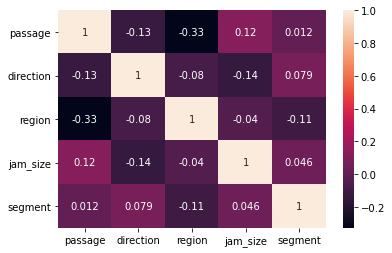

In [23]:
# We import the necessary libraries for the plots
import seaborn as sn
import matplotlib.pyplot as plt

# We generated the Correlation Matrix for the entirely numeric matrix that we converted earlier.
# It is noteworthy that the entirely numerical matrix is composed of only a few samples, given that the conversion
# of the Segment feature is quite time consuming and therefore was not made for the entire matrix.
corrMatrix = df_numerical.iloc[:,1:].corr()

# Heatmap Plot
sn.heatmap(corrMatrix, annot=True)
plt.show()

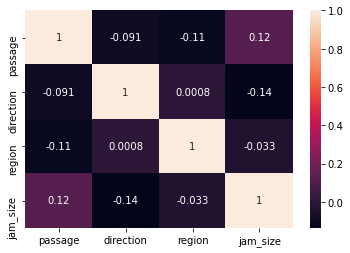

In [24]:
# Here we use the entirely numeric matrix without a Segment feature. So we were able to use more samples
# for the construction of our heatmap.
corrMatrix = df_typeless_replace.iloc[:,1:].corr()

# Heatmap plot
sn.heatmap(corrMatrix, annot=True)
plt.show()

Even after mapping text values into numerical values, this new numerical information continues to follow a classificatory / categorical paradigm. Therefore, the usual (Pearson) correlation matrix loses its meaning. Therefore, I preferred to do the correlation analysis directly over a more detailed analysis of the
Dice.

Thus, we were able to perceive some patterns relating the traffic and the regions.

In [25]:
# We generate the list, in ascending order, of trafficking by region
df_region = df_typeless.groupby('region')['jam_size'].sum().sort_values()
df_region

region
NORTE       121013614
SUL         708726545
LESTE       903240438
OESTE       992654178
CENTRO     1155013516
NOWHERE    3711787338
Name: jam_size, dtype: int64

Text(0, 0.5, 'Engarrafamento')

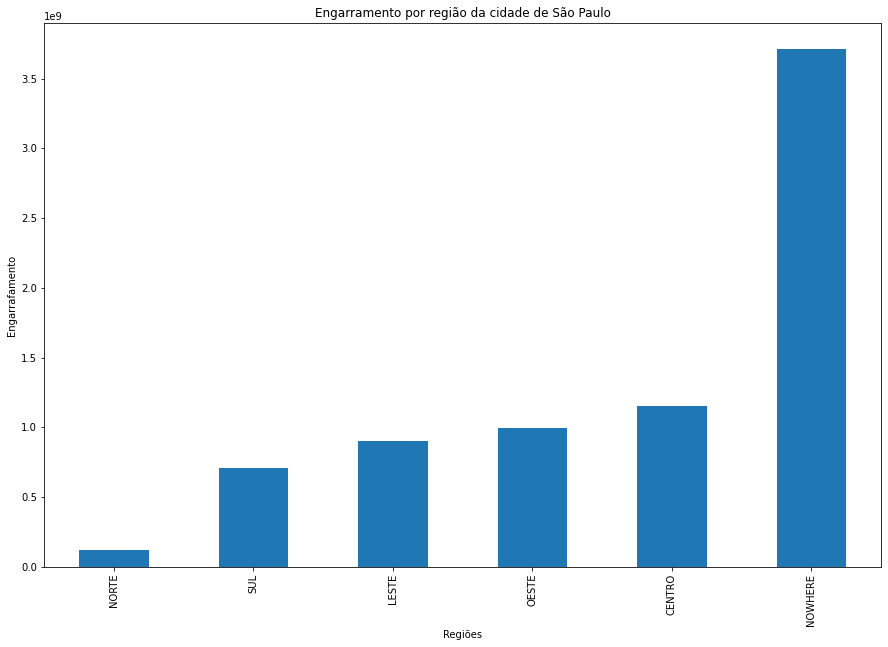

In [26]:
# Traffic Bar plot
plot_region = df_region.plot.bar(y='jam_size', figsize=(15,10), title='Traffic per region of Sao Paulo')
plot_region.set_xlabel("Regions")
plot_region.set_ylabel("Traffic")

## Analyze:

With that, we can see that the North region has very little traffic compared to the others. Therefore, the first correlation that we can assume is that there is a coefficient inversely proportional to traffic and proximity to the northern region. The closer to other regions, the greater the traffic.

However, we must continue to analyze the data from other perspectives.

Text(0, 0.5, 'Traffic')

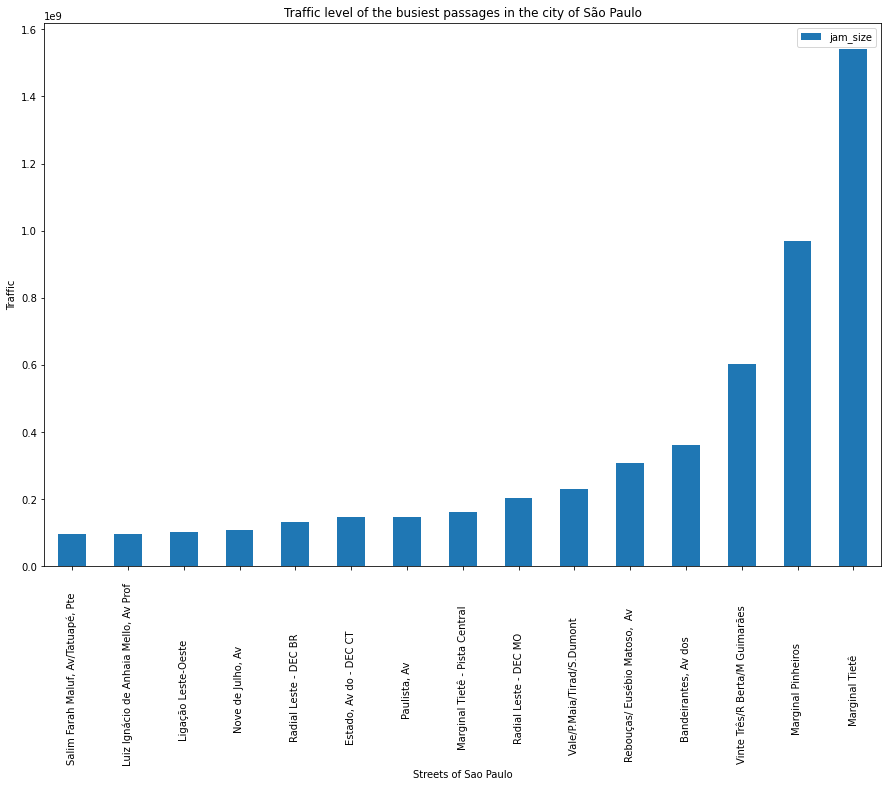

In [27]:
# We generate a traffic dataframe for each of the crossings
df_passage = df_typeless.groupby('passage', as_index=False)['jam_size'].sum().sort_values('jam_size')

# So we chose the 15 most trafficked segments and analyzed their distribution.
plot_passages = df_passage[-15:].plot.bar(x='passage', y='jam_size', figsize=(15,10), title='Traffic level of the busiest passages in the city of São Paulo')
plot_passages.set_xlabel("Streets of Sao Paulo")
plot_passages.set_ylabel("Traffic")

## Analyze:

Now, we realize that Marginal Tietê and Marginal Pinheiros are responsible for the great part of the general traffic perceived in the dataset.

Adding this information to that previously perceived, we can assume that both Avenues are either not connected to the North Region of São Paulo, or if they are, they do not cause major traffic jams in the northern part of the city.

**This could mean**: Or that the sensors in the North region, which fed the database, are defective, which would explain this great difference in traffic in the region, together with an increase in NOWHERE data; Or that for some reason, fewer people go to the North through these major routes.

To better understand the issue, I searched for the map of São Paulo. We see below.

#### Marginal Tietê:
"It is considered the main expressway in the city of São Paulo, as it interconnects the west, **north**, central and east regions of the city. In addition, it connects directly to the Castelo Branco, Anhanguera, Bandeirantes, Presidente Dutra highways, Fernão Dias and Ayrton Senna and to the São Paulo-Guarulhos International Airport. "

<img src="Images/MapaSP.png">

Thus, we can see from the map that, in fact, Avenida Marginal Pinheiro does not include the northern region of São Paulo.

However, as the definition of the Marginal Tietê itself indicates, it is a road that connects the west, **North**, central and east regions. Given its importance and extent, it seems more likely that, in fact, it was a problem in the sensors than a low transitivity of cars.

It is worth mentioning that I do not live in São Paulo, so I am making assumptions totally data-wise.

We continue our analysis below.

In [28]:
# Once the main passages are recognized, we generate a list with their names.
top_passage = df_passage[-15:]['passage'].to_list()
top_passage

['Salim Farah Maluf, Av/Tatuapé, Pte      ',
 'Luiz Ignácio de Anhaia Mello, Av Prof   ',
 'Ligação Leste-Oeste                     ',
 'Nove de Julho, Av                       ',
 'Radial Leste - DEC BR                   ',
 'Estado, Av do - DEC CT                  ',
 'Paulista, Av                            ',
 'Marginal Tietê - Pista Central          ',
 'Radial Leste - DEC MO                   ',
 'Vale/P.Maia/Tirad/S.Dumont              ',
 'Rebouças/ Eusébio Matoso,  Av           ',
 'Bandeirantes, Av dos                    ',
 'Vinte Três/R Berta/M Guimarães          ',
 'Marginal Pinheiros                      ',
 'Marginal Tietê                          ']

In [29]:
# We group by region and passage, so that it can be possible to check in which regions each passage generated
# traffic
top_traffic = df_typeless.groupby(['passage', 'region'], as_index=False)['jam_size'].sum()
top_traffic.dropna(inplace=True)
top_traffic

,passage,region,jam_size
5,"Abraão Ribeiro, Av Dr (F)",NOWHERE,740432.0
10,"Abraão de Morais, Av Prof/Imig",SUL,15436869.0
11,"Abraão de Morais, Av Prof/Imig",NOWHERE,5577835.0
17,"Abraão de Morais, Av Prof/Imigrantes (F)",NOWHERE,2527438.0
22,Adolfo Pinheiro e Lgo 13/05,SUL,154326.0
...,...,...,...
1642,"Washington Luis, Av",SUL,65554904.0
1643,"Washington Luis, Av",NOWHERE,25287412.0
1649,XXX,NOWHERE,30440.0
1650,"Xangai, Vd",CENTRO,133632.0


Text(0, 0.5, 'Traffic')

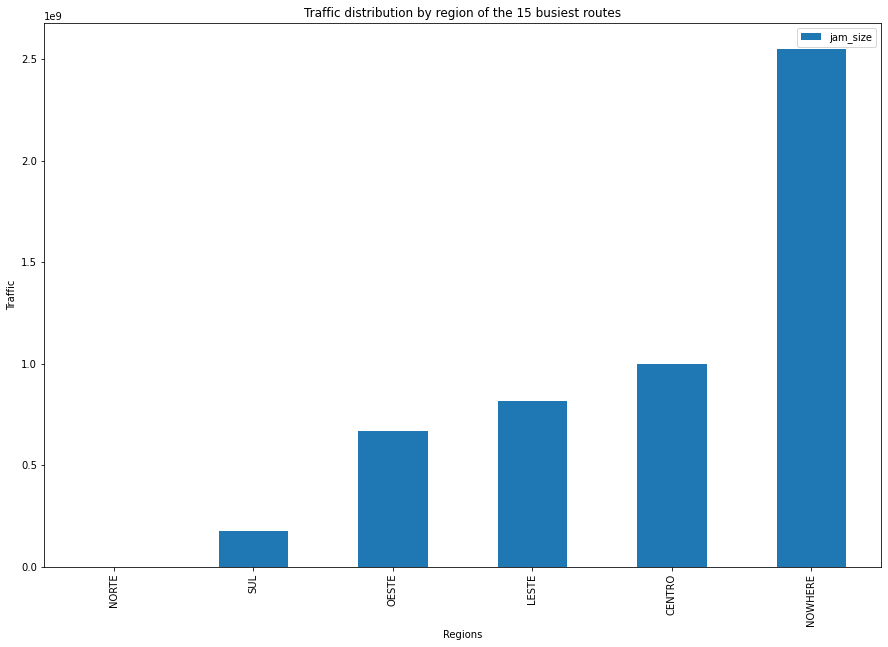

In [30]:
# We only screen the dataset with the tickets that generated the most traffic, so that we can identify your regions
top_traffic_reg = top_traffic[top_traffic['passage'].isin(top_passage)]
top_traffic_reg = top_traffic_reg.groupby('region').sum().sort_values('jam_size')
plot_traffic = top_traffic_reg.plot.bar(y='jam_size', figsize=(15,10), title='Traffic distribution by region of the 15 busiest routes')
plot_traffic.set_xlabel("Regions")
plot_traffic.set_ylabel("Traffic")

In [32]:
# Calculate how many percent of the traffic generated in these passages represents the general traffic.
pctg_all_traf = top_traffic_reg.sum()[0]/df_typeless['jam_size'].sum()
print('The traffic generated on these tickets represents %f%% of the general traffic' % pctg_all_traf)

The traffic generated on these tickets represents 0.685995% of the general traffic


## Analyze :

Finally, as a last analysis of this topic, we divided the traffic of the 15 busiest passages in São Paulo by region. Thus, we can see that among the main traits of the dataset, none are found in the North region, thus confirming our first analysis of the negative correlation between the North region and heavy traffic.

The influence of these 15 routes on the traffic in the city of São Paulo is quite high, given that together, they account for almost 70% of the total traffic in São Paulo.

We can also see that among these 15 main routes, very little movement is registered in the South region. With this, we can indicate another possible negative correlation of trafficking also with the South region, so that the more distant from the South and North region, the greater the chance of traffic.

## 5 - Traffic jams

- Plot a graph of the distribution of traffic jams being aggregated by year.
- Plot a graph of the distribution of traffic jams being aggregated by month.
- Plot a graph of the distribution of traffic jams being aggregated by day of the week.
- Plot a graph of the distribution of traffic jams being aggregated by time of day.
- Comment on the results obtained, are there any trends?

In [33]:
# import required for timestamp treatment
from dateutil.parser import parse

# We make one more copy to avoid overwriting the memory.
engarrafamento = df_typeless.copy()

In [34]:
# We have broken down the timestamp column into new columns: Year, Month, Day of the Week, Time.
engarrafamento['year'] = pd.DatetimeIndex(engarrafamento['timestamp']).year
engarrafamento['month'] = engarrafamento['timestamp'].apply(lambda x: x.strftime("%B"))
engarrafamento['weekday'] = engarrafamento['timestamp'].apply(lambda x: x.strftime("%A"))
engarrafamento['hour'] = engarrafamento['timestamp'].apply(lambda x: int(x.strftime("%-H")))

In [35]:
# Sampling
engarrafamento

,index,passage,direction,region,timestamp,jam_size,segment,year,month,weekday,hour
0,0,"Jânio Quadros, Túnel",unico//,OESTE,2015-01-04 14:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK,2015,January,Sunday,14
1,1,"Juscelino Kubitschek, Av Pres",Ibirapuera/Pinheiros,SUL,2015-01-04 14:30:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...,2015,January,Sunday,14
2,2,"Jânio Quadros, Túnel",unico//,OESTE,2015-01-04 15:00:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK,2015,January,Sunday,15
3,3,"Juscelino Kubitschek, Av Pres",Ibirapuera/Pinheiros,SUL,2015-01-04 15:00:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...,2015,January,Sunday,15
4,4,"Jânio Quadros, Túnel",unico//,OESTE,2015-01-04 15:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK,2015,January,Sunday,15
...,...,...,...,...,...,...,...,...,...,...,...
5223443,230195,Marginal Pinheiros,Interlagos/Castelo,OESTE,2018-09-30 18:30:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...,2018,September,Sunday,18
5223444,230196,Marginal Pinheiros,Interlagos/Castelo,OESTE,2018-09-30 19:00:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...,2018,September,Sunday,19
5223445,230197,Marginal Pinheiros,Interlagos/Castelo,OESTE,2018-09-30 19:00:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...,2018,September,Sunday,19
5223446,230198,Marginal Pinheiros,Interlagos/Castelo,OESTE,2018-09-30 19:30:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...,2018,September,Sunday,19


### Chart of the traffic jams distribution being aggregated by year

Text(0, 0.5, 'Traffic')

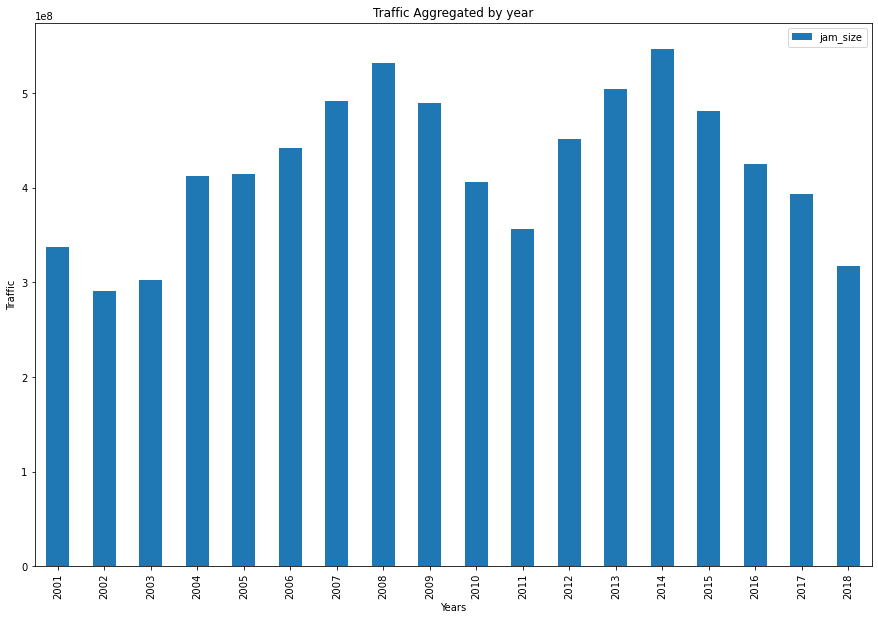

In [36]:
# Sampling by traffic per year
df_year = engarrafamento.groupby('year').sum()
plot_year = df_year.plot.bar(y='jam_size', figsize=(15,10), title='Traffic Aggregated by year')
plot_year.set_xlabel("Years")
plot_year.set_ylabel("Traffic")

### Chart of the traffic jams distribution being aggregated by month

Text(0, 0.5, 'Traffic')

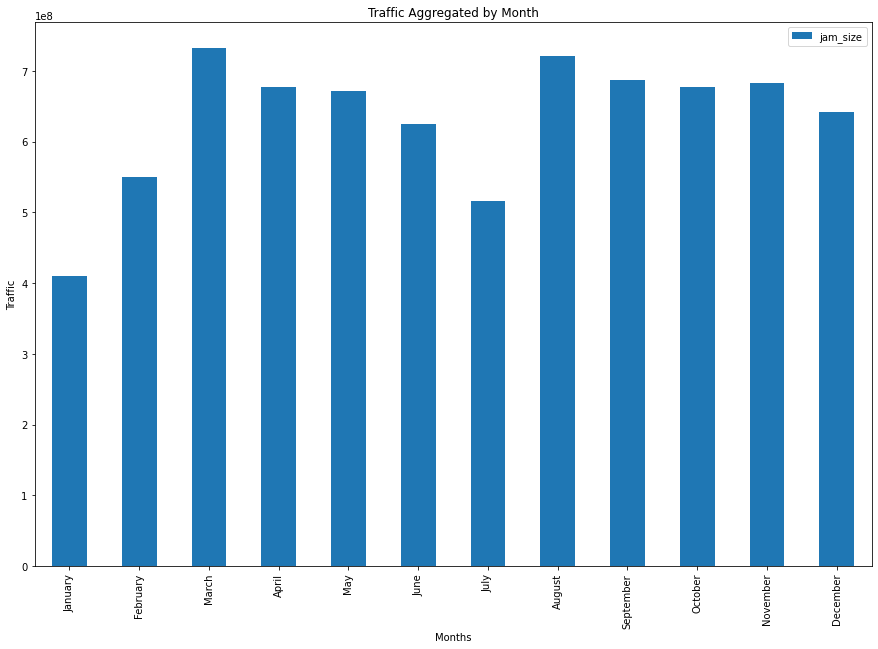

In [37]:
# Sampling by traffic per month
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_month = engarrafamento.groupby('month').sum().loc[months_order]
plot_month = df_month.plot.bar(y='jam_size', figsize=(15,10), title='Traffic Aggregated by Month')
plot_month.set_xlabel("Months")
plot_month.set_ylabel("Traffic")

### Chart of the traffic jams distribution being aggregated by days of the week

Text(0, 0.5, 'Traffic')

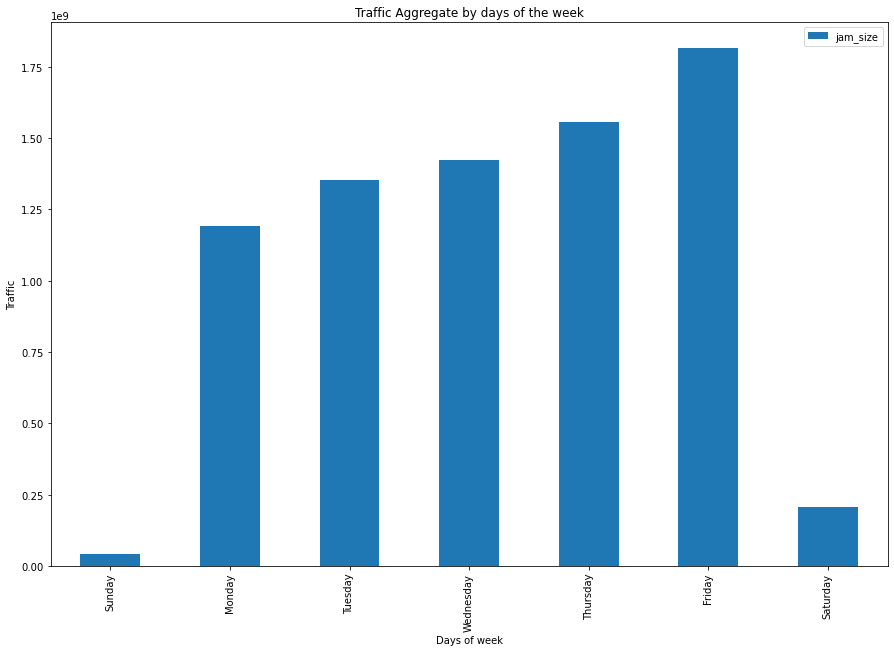

In [38]:
# Sampling by traffic by Day of the Week
# Days order
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Ordered plot
df_weekday = engarrafamento.groupby('weekday').sum().loc[weekday_order]
plot_weekday = df_weekday.plot.bar(y='jam_size', figsize=(15,10), title='Traffic Aggregate by days of the week')
plot_weekday.set_xlabel("Days of week")
plot_weekday.set_ylabel("Traffic")

### Chart of the traffic jams distribution being aggregated by hours of the day

Text(0, 0.5, 'Engarrafamento')

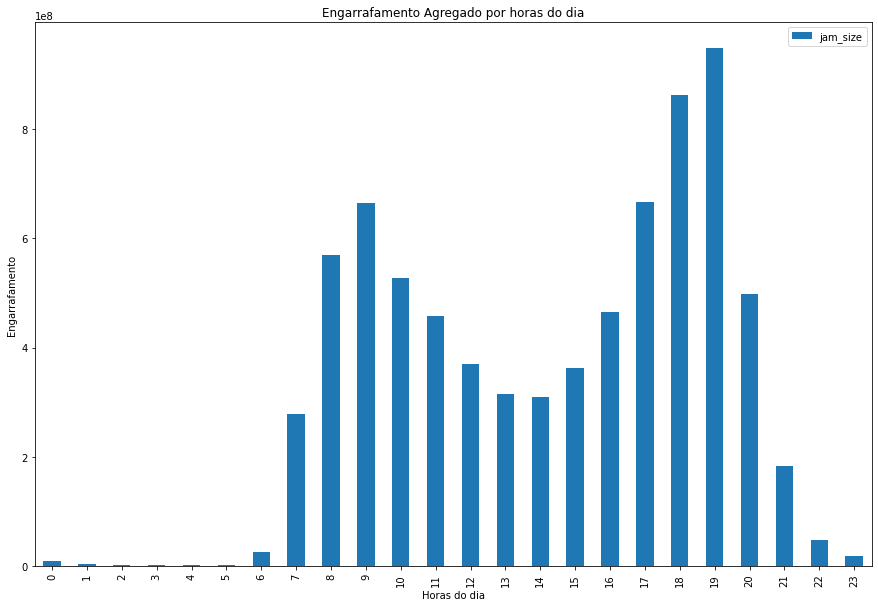

In [41]:
df_hour = engarrafamento.groupby('hour').sum()
plot_hour = df_hour.plot.bar(y='jam_size', figsize=(15,10), title='Traffic Aggregated by hours of the day')
plot_hour.set_xlabel("Hours of the day")
plot_hour.set_ylabel("Traffic")

## Analyze:

From the graphs, we can see some interesting trends.

According to the annual data, we cannot say much. However, looking at the monthly data, we can see that there is a decline in the traffic jam for the months of June and July, December and January. This decrease may be due to student vacations, thus reducing traffic towards schools and universities.

On the daily chart, we can see the clear decrease in traffic jam at the weekend, which was already expected.

Finally, in the chart separated by hours, we can see that at dawn there is almost no movement compared to peak working hours, with a slight decline in lunch hours.

Thus, we can prove that the data truly portrays reality phenomena as we have speculated.

In [39]:
## BACKUP of the main Dataset previously treated, for later use

# We save the dataframe that contains all converts to numeric format, except segment.
df_typeless_replace.to_csv('Backup_DataSets/typeless_r_df.csv')

# We also save the original dataset in csv format, so that we can use it in case of Dask, if necessary.
df.to_csv('Backup_DataSets/df_orig.csv')

# Data without NaN and without the Type column
df_typeless.to_csv('Backup_DataSets/typeless_df.csv')

# For the SQL case, we will use the typeless dataset
engarrafamento.to_csv('Backup_DataSets/engarrafamento.csv')

## 6 - Parallel computing

- Use a tool for reading and parallel processing of the data in question (Suggestion: PySpark, Dask).

## Motivation:

Using the normal python programming environment, we don't use all of the hardware resources. Parallel computing comes with this purpose, to increase the performance of processing using parallelisms, which generate an overlap of tasks and, therefore, a faster execution of the same activity.

These practices have become more common with the advent of Big Data. Thus, the motivation I see in this question is to try to solve the problem that was presented in the question of categorical data, with the Segment column.

Revisiting the question, you can see that I tried to do it manually, using Pandas, which Dask does by default, which is slicing the dataset, aiming to perform several smaller tasks instead of a giant task. This was necessary because, when I tried to apply the replace () function directly to the entire data set, my kernel killed the process, as it was consuming a lot of memory.

So, this is the main task that I want to solve using parallel computing techniques, since slicing Pandas and applying the replace function iteratively is very efficient, especially due to the greatness of the dictionary in question.

In [ ]:
# We import the Dask dataframe, and the distribution functions, so that we can follow the performance of the dask
# via Dashboard
import dask.dataframe as dd 
from dask.distributed import Client, LocalCluster

# Client
cluster = LocalCluster()
client = Client(cluster)

# Start the client
client

In [ ]:
# We read our typeless dataset in Dask Dataframe format
ddf = dd.read_csv('Backup_DataSets/typeless_r_df.csv')

# Given the size of the dataset, we divide it into npartitions in order to increase computing power
# Dask parallel.
ddf = ddf.repartition(npartitions=10000)
ddf.head()

In [ ]:
# Then we use Dask's replace function which has an interface very close to Pandas. So, we spend
# our Segment dictionary as a parameter for mapping and replacing values.
final_numerical_df = ddf.replace(dictio_segment)

In [49]:
# We print the last 5 lines
final_numerical_df.tail()

,Unnamed: 0,index,passage,direction,region,timestamp,jam_size,segment
301984,5223443,230195,171,34,4,2018-09-30 18:30:00,3820,75975
301985,5223444,230196,171,34,4,2018-09-30 19:00:00,4640,76073
301986,5223445,230197,171,34,4,2018-09-30 19:00:00,3820,75975
301987,5223446,230198,171,34,4,2018-09-30 19:30:00,4640,76073
301988,5223447,230199,171,34,4,2018-09-30 19:30:00,3820,75975


In [45]:
# Finally, we call the compute () function to return the dataset to the pandas format.DataFrame
# final_df = final_numerical_df.compute ()

## Analyze:

### Thanks to the Dashboard, we can get a good idea of how Dask operates.

<img src="Images/dash_dask4.png">

<img src="Images/dash_dask3.png">

Four workers were set up, with a 2GB memory limit for each.

 In **Image 1**, we can see how much memory has already been allocated for each worker, and the amount of partitions on which the replace () method has already been applied.

 In **Image 2**, we have how many CPU resources are being used separated by thread.

 It is worth mentioning that I exceeded the memory limit several times, causing my computer to freeze, or causing Dask to generate an error, due to an excess of workers exceeding the stipulated memory limit for each. So, looking at the Dashboard in each case, and trying to cut the dataset in different sizes, I realized that repartitioning the data in 10000 worked well with my machine's level of processing.

 However, even with Dask optimization, applying the dictionary to all 5 million samples would take an enormous amount of time. Since I believe this is not the point of this question, I have started a second analysis below.

 The purpose of this second analysis is to compare the performance of the native methods of pandas.DataFrame with the methods of dask.DataFrame.

In [51]:
# In this case, we convert directly from Pandas to Dask, selecting a certain amount of samples.
dask_df = dd.from_pandas(df_typeless.iloc[:5000], npartitions=10)

In [52]:
# We allocate the same number of samples in the panda format.
pandas_df = df_typeless.iloc[:5000].copy()

In [53]:
# The time library is imported to time the processing time
import time

In [54]:
# Processing Time for the native Pandas method
start_pd = time.time()
pandas_dff = pandas_df.replace(dictio_segment)
end_pd = time.time()

In [55]:
# Processing Time for the Dask method
start_dd = time.time()
dask_dff = dask_df.compute()
end_dd = time.time()

In [56]:
print ('Using the method with Pandas: --------')
print ('Processing time for 5000 samples:% f secs \n'% (end_pd-start_pd))
print ('Using the method with Dask: --------')
print ('Processing time for 5000 samples:% f secs'% (end_dd-start_dd))

Utilizando o método com Pandas: --------
Tempo de processamento para 5000 samples: 15.416930 segs 

Utilizando o método com Dask: --------
Tempo de processamento para 5000 samples: 2.220998 segs


## Analyze:

  ** Therefore, we can confirm the effectiveness of Dask on Pandas. **

## 7- Database

- Use the library of preference (PySpark, Dask) to connect and transfer the dataframe to a database (for example, PostgreSQL)
- Then perform the tasks below:
- Show the total traffic size by region
- Show the regions with the biggest traffic jams
- Show the total size of traffic by day of the week

In [57]:
# The pandas are imported again, just so that question 7 could be run independently of the rest of the
# notebook.
import pandas as pd

# Read CSV
engarrafamento = pd.read_csv('Backup_DataSets/engarrafamento.csv')

In [71]:
# Sampling
engarrafamento

,Unnamed: 0,index,passage,direction,region,timestamp,jam_size,segment,year,month,weekday,hour
0,0,0,"Jânio Quadros, Túnel",unico//,OESTE,2015-01-04 14:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK,2015,January,Sunday,14
1,1,1,"Juscelino Kubitschek, Av Pres",Ibirapuera/Pinheiros,SUL,2015-01-04 14:30:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...,2015,January,Sunday,14
2,2,2,"Jânio Quadros, Túnel",unico//,OESTE,2015-01-04 15:00:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK,2015,January,Sunday,15
3,3,3,"Juscelino Kubitschek, Av Pres",Ibirapuera/Pinheiros,SUL,2015-01-04 15:00:00,260,De Emboque Túnel Jânio Quadros até 290 m depo...,2015,January,Sunday,15
4,4,4,"Jânio Quadros, Túnel",unico//,OESTE,2015-01-04 15:30:00,799,De OSCAR AMERICANO até JUSCELINO KUBITSCHEK,2015,January,Sunday,15
...,...,...,...,...,...,...,...,...,...,...,...,...
5223443,5223443,230195,Marginal Pinheiros,Interlagos/Castelo,OESTE,2018-09-30 18:30:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...,2018,September,Sunday,18
5223444,5223444,230196,Marginal Pinheiros,Interlagos/Castelo,OESTE,2018-09-30 19:00:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...,2018,September,Sunday,19
5223445,5223445,230197,Marginal Pinheiros,Interlagos/Castelo,OESTE,2018-09-30 19:00:00,3820,De CIDADE UNIVERSITARIA até 350 m depois de JU...,2018,September,Sunday,19
5223446,5223446,230198,Marginal Pinheiros,Interlagos/Castelo,OESTE,2018-09-30 19:30:00,4640,De CIDADE UNIVERSITARIA até 700 m depois de QU...,2018,September,Sunday,19


In [72]:
# We import the SQL module
import sqlite3

In [73]:
# We instantiated the Traffic.db database
conn = sqlite3.connect('SQL_DB/Traffic.db')  
c = conn.cursor()

In [74]:
# We generated a TRAFFIC Table to receive the data
c.execute('DROP TABLE IF EXISTS TRAFFIC;')
c.execute('CREATE TABLE TRAFFIC (Passage text, Direction text, Region text, Timestamp text, Jam_size text, Segment text, Year number, Month text, Weekday text, Hour number)')
conn.commit()

In [75]:
# We pass the data from the Pandas format to the Traffic.db database, recording them in the TRAFFIC Table structure
engarrafamento.iloc[:,2:].to_sql('TRAFFIC', conn, if_exists='replace', index = False) 

In [76]:
def printSchema(connection):
    ### Source: http://stackoverflow.com/a/35092773/4765776
    for (tableName,) in connection.execute(
        """
        select NAME from SQLITE_MASTER where TYPE='table' order by NAME;
        """
    ):
        print("{}:".format(tableName))
        for (
            columnID, columnName, columnType,
            columnNotNull, columnDefault, columnPK,
        ) in connection.execute("pragma table_info('{}');".format(tableName)):
            print("  {id}: {name}({type}){null}{default}{pk}".format(
                id=columnID,
                name=columnName,
                type=columnType,
                null=" not null" if columnNotNull else "",
                default=" [{}]".format(columnDefault) if columnDefault else "",
                pk=" *{}".format(columnPK) if columnPK else "",
            ))

In [77]:
# Database Schema
print("Database schema:")
printSchema(conn)

Database schema:
TRAFFIC:
  0: passage(TEXT)
  1: direction(TEXT)
  2: region(TEXT)
  3: timestamp(TEXT)
  4: jam_size(INTEGER)
  5: segment(TEXT)
  6: year(INTEGER)
  7: month(TEXT)
  8: weekday(TEXT)
  9: hour(INTEGER)


In [96]:
## Remember to install Ipython SQL before: conda install -c conda-forge ipython-sql
%load_ext sql
%sql sqlite:///SQL_DB/Traffic.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: @SQL_DB/Traffic.db'

### Show the total Traffic size by region

In [97]:
%%sql 

DROP VIEW IF EXISTS traffic_per_region;
CREATE VIEW traffic_per_region AS
SELECT Region, SUM(jam_size) as Engarrafamento
FROM TRAFFIC
GROUP BY Region;

 * sqlite:///SQL_DB/Traffic.db
   sqlite:///Traffic.db
Done.
Done.


[]

In [98]:
%sql SELECT * FROM traffic_per_region;

 * sqlite:///SQL_DB/Traffic.db
   sqlite:///Traffic.db
Done.


region,Engarrafamento
CENTRO,1155013516
LESTE,903240438
NORTE,121013614
NOWHERE,3711787338
OESTE,992654178
SUL,708726545


In [99]:
engarrafamento.groupby('region')['jam_size'].sum()

region
CENTRO     1155013516
LESTE       903240438
NORTE       121013614
NOWHERE    3711787338
OESTE       992654178
SUL         708726545
Name: jam_size, dtype: int64

### Show the regions with the biggest traffic jams

In [100]:
%%sql 

DROP VIEW IF EXISTS top_traffic_per_region;
CREATE VIEW top_traffic_per_region AS
SELECT Region, SUM(jam_size) as Engarrafamento
FROM TRAFFIC
GROUP BY Region
ORDER BY Engarrafamento DESC;

 * sqlite:///SQL_DB/Traffic.db
   sqlite:///Traffic.db
Done.
Done.


[]

In [101]:
%sql SELECT * FROM top_traffic_per_region limit 3;

 * sqlite:///SQL_DB/Traffic.db
   sqlite:///Traffic.db
Done.


region,Engarrafamento
NOWHERE,3711787338
CENTRO,1155013516
OESTE,992654178


In [102]:
engarrafamento.groupby('region')['jam_size'].sum().sort_values(ascending=False)[:3]

region
NOWHERE    3711787338
CENTRO     1155013516
OESTE       992654178
Name: jam_size, dtype: int64

### Show the total traffic size by day of the week

In [103]:
%%sql 

DROP VIEW IF EXISTS traffic_per_weekday;
CREATE VIEW traffic_per_weekday AS
SELECT weekday as Dia, SUM(jam_size) as Engarrafamento
FROM TRAFFIC
GROUP BY Dia
ORDER BY Engarrafamento DESC;

 * sqlite:///SQL_DB/Traffic.db
   sqlite:///Traffic.db
Done.
Done.


[]

In [104]:
%sql SELECT * FROM traffic_per_weekday;

 * sqlite:///SQL_DB/Traffic.db
   sqlite:///Traffic.db
Done.


Dia,Engarrafamento
Friday,1815525493
Thursday,1556886458
Wednesday,1424963310
Tuesday,1354811806
Monday,1191062606
Saturday,206723907
Sunday,42462049


In [105]:
engarrafamento.groupby('weekday')['jam_size'].sum().sort_values(ascending=False)

weekday
Friday       1815525493
Thursday     1556886458
Wednesday    1424963310
Tuesday      1354811806
Monday       1191062606
Saturday      206723907
Sunday         42462049
Name: jam_size, dtype: int64